## Prepare FAPAR from MODIS Data

In this notebook, 8-daily MODIS/Terra & Aqua FAPAR data from 2000 - 2024 is processed. The following steps are included:
- Replace fill values with NA
- Mask pixels based on quality flags
- Crop to forest area
- Save datasets for needleleaved and broadleaved forests
- Save information on quality flags and counts of high quality pixels per year as csv datasets

In [1]:
# import libraries
import os
import warnings
import xarray as xr
import numpy as np
import pandas as pd

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [3]:
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [4]:
# read MODIS FAPAR data
fapar_full = xr.open_dataset("./Raw/LAI_FAPAR_MODIS/MOD15A2H.061_500m_aid0001.nc", decode_coords="all", decode_times=True)

In [5]:
fapar_full

<xarray.Dataset> Size: 113GB
Dimensions:       (time: 1139, lat: 1871, lon: 2203)
Coordinates:
    crs           int8 1B ...
  * time          (time) object 9kB 2000-02-18 00:00:00 ... 2024-12-26 00:00:00
  * lat           (lat) float64 15kB 55.06 55.06 55.05 ... 47.28 47.27 47.27
  * lon           (lon) float64 18kB 5.865 5.869 5.873 ... 15.03 15.04 15.04
Data variables:
    FparExtra_QC  (time, lat, lon) float32 19GB ...
    FparLai_QC    (time, lat, lon) float32 19GB ...
    Fpar_500m     (time, lat, lon) float64 38GB ...
    Lai_500m      (time, lat, lon) float64 38GB ...
Attributes:
    title:        MOD15A2H.061 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v3.71
    references:   See README.md
    history:      See README.md

In [6]:
# note that FAPAR and LAI are stored in one dataset
# and that all dates from 2000-2024 are stored in one large netCDF dataset
# for now, we only want to consider FAPAR
fapar_full = fapar_full.drop_vars("Lai_500m")

In [7]:
# convert CFTime index to datetime index
datetimeindex = fapar_full.indexes['time'].to_datetimeindex()
fapar_full['time'] = datetimeindex

C:\Users\irish\AppData\Local\Temp\ipykernel_9416\1701818943.py:2: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  datetimeindex = fapar_full.indexes['time'].to_datetimeindex()


In [8]:
# rename variables
fapar_full = fapar_full.rename({"Fpar_500m":"FAPAR", "FparLai_QC":"QA", "FparExtra_QC": "QA_extra"})

In [9]:
# check crs
fapar_full.rio.crs

CRS.from_wkt('GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]')

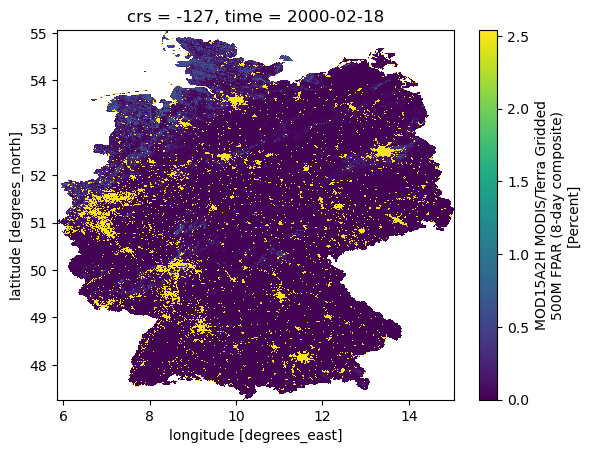

In [10]:
# plot exemplary FAPAR data of one date to get a first impression
fapar_full.FAPAR.sel(time = "2000-02-18").plot()

In [11]:
# look at attributes of fapar variable
fapar_full.FAPAR.attrs

{'valid_min': np.int16(0),
 'valid_max': np.int16(100),
 'scale_factor_err': np.float64(0.0),
 'add_offset_err': np.float64(0.0),
 'calibrated_nt': np.int32(21),
 'long_name': 'MOD15A2H MODIS/Terra Gridded 500M FPAR (8-day composite)',
 'units': 'Percent',
 'MOD15A2_FILLVALUE_DOC': 'MOD15A2 FILL VALUE LEGEND\n255 = _Fillvalue, assigned when:\n    * the MOD09GA suf. reflectance for channel VIS, NIR was assigned its _Fillvalue, or\n    * land cover pixel itself was assigned _Fillvalus 255 or 254.\n254 = land cover assigned as perennial salt or inland fresh water.\n253 = land cover assigned as barren, sparse vegetation (rock, tundra, desert.)\n252 = land cover assigned as perennial snow, ice.\n251 = land cover assigned as "permanent" wetlands/inundated marshlands.\n250 = land cover assigned as urban/built-up.\n249 = land cover assigned as "unclassified" or not able to determine.\n'}

In [12]:
# in the dataset, fill values are assigned to pixels where the algorithm could not retrieve a biophysical estimate
# source: https://lpdaac.usgs.gov/documents/926/MOD15_User_Guide_V61.pdf 
# these pixel values should be converted to NA - this will be done in a later step because right now, the full dataset is too large for the operation

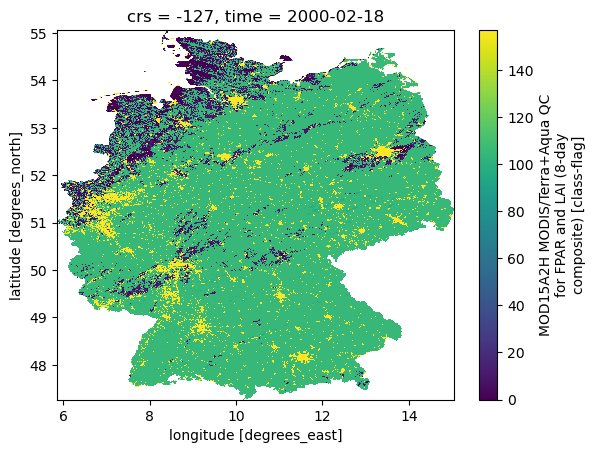

In [13]:
# also plot the quality layers of the same date to get an impression
fapar_full.QA.sel(time = "2000-02-18").plot()

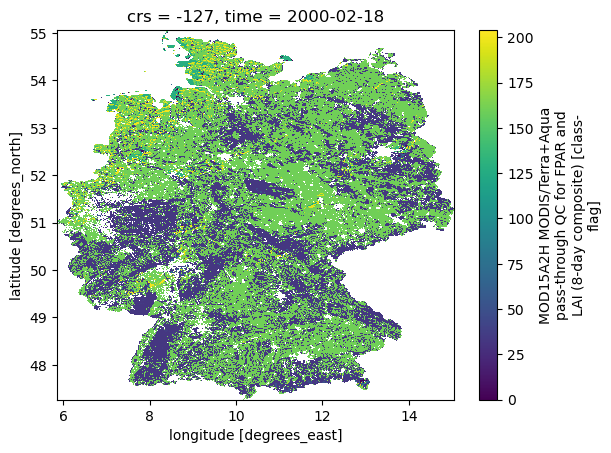

In [14]:
fapar_full.QA_extra.sel(time = "2000-02-18").plot()

In [15]:
# read in quality flag lookup tables that were delivered with data to get information on quality flags
lut = pd.read_csv("./Raw/LAI_FAPAR_MODIS/MOD15A2H-061-FparLai-QC-lookup.csv")
lut

,Value,MODLAND,Sensor,DeadDetector,CloudState,SCF_QC
0,0,Good quality (main algorithm with or without s...,Terra,Detectors apparently fine for up to 50% of cha...,Significant clouds NOT present (clear),"Main (RT) method used, best result possible (n..."
1,8,Good quality (main algorithm with or without s...,Terra,Detectors apparently fine for up to 50% of cha...,Significant clouds WERE present,"Main (RT) method used, best result possible (n..."
2,16,Good quality (main algorithm with or without s...,Terra,Detectors apparently fine for up to 50% of cha...,Mixed cloud present in pixel,"Main (RT) method used, best result possible (n..."
3,32,Good quality (main algorithm with or without s...,Terra,Detectors apparently fine for up to 50% of cha...,Significant clouds NOT present (clear),"Main (RT) method used with saturation. Good, v..."
4,40,Good quality (main algorithm with or without s...,Terra,Detectors apparently fine for up to 50% of cha...,Significant clouds WERE present,"Main (RT) method used with saturation. Good, v..."
5,48,Good quality (main algorithm with or without s...,Terra,Detectors apparently fine for up to 50% of cha...,Mixed cloud present in pixel,"Main (RT) method used with saturation. Good, v..."
6,65,Other Quality (back-up algorithm or fill values),Terra,Detectors apparently fine for up to 50% of cha...,Significant clouds NOT present (clear),"Main (RT) method failed due to bad geometry, e..."
7,73,Other Quality (back-up algorithm or fill values),Terra,Detectors apparently fine for up to 50% of cha...,Significant clouds WERE present,"Main (RT) method failed due to bad geometry, e..."
8,81,Other Quality (back-up algorithm or fill values),Terra,Detectors apparently fine for up to 50% of cha...,Mixed cloud present in pixel,"Main (RT) method failed due to bad geometry, e..."
9,97,Other Quality (back-up algorithm or fill values),Terra,Detectors apparently fine for up to 50% of cha...,Significant clouds NOT present (clear),Main (RT) method failed due to problems other ...


In [16]:
lut_extra = pd.read_csv("./Raw/LAI_FAPAR_MODIS/MOD15A2H-061-FparExtra-QC-lookup.csv")
lut_extra

,Value,LandSea Pass-Thru,Snow_Ice,Aerosol,Cirrus,Internal_CloudMask,Cloud_Shadow,SCF_Biome_Mask
0,0,"0 LAND AggrQC (3,5) values {001}",No snow/ice detected,No or low atmospheric aerosol levels detected,No cirrus detected,No clouds,No cloud shadow detected,"Biome outside interval <1,4>"
1,1,"1 SHORE AggrQC (3,5) values {000, 010, 100}",No snow/ice detected,No or low atmospheric aerosol levels detected,No cirrus detected,No clouds,No cloud shadow detected,"Biome outside interval <1,4>"
2,2,"2 FRESHWATER AggrQC (3,5) values {011, 101}",No snow/ice detected,No or low atmospheric aerosol levels detected,No cirrus detected,No clouds,No cloud shadow detected,"Biome outside interval <1,4>"
3,4,"0 LAND AggrQC (3,5) values {001}",Snow/ice detected,No or low atmospheric aerosol levels detected,No cirrus detected,No clouds,No cloud shadow detected,"Biome outside interval <1,4>"
4,5,"1 SHORE AggrQC (3,5) values {000, 010, 100}",Snow/ice detected,No or low atmospheric aerosol levels detected,No cirrus detected,No clouds,No cloud shadow detected,"Biome outside interval <1,4>"
...,...,...,...,...,...,...,...,...
67,201,"1 SHORE AggrQC (3,5) values {000, 010, 100}",No snow/ice detected,Average or high aerosol levels detected,No cirrus detected,No clouds,Cloud shadow detected,"Biome in interval <1,4>"
68,202,"2 FRESHWATER AggrQC (3,5) values {011, 101}",No snow/ice detected,Average or high aerosol levels detected,No cirrus detected,No clouds,Cloud shadow detected,"Biome in interval <1,4>"
69,204,"0 LAND AggrQC (3,5) values {001}",Snow/ice detected,Average or high aerosol levels detected,No cirrus detected,No clouds,Cloud shadow detected,"Biome in interval <1,4>"
70,205,"1 SHORE AggrQC (3,5) values {000, 010, 100}",Snow/ice detected,Average or high aerosol levels detected,No cirrus detected,No clouds,Cloud shadow detected,"Biome in interval <1,4>"


In [17]:
# extract all quality flag values that are fit for our purpose and should be kept in the dataset
# sources: https://lpdaac.usgs.gov/documents/926/MOD15_User_Guide_V61.pdf and Pu et al. (2024)

# include good quality based on MODLAND
lut = lut[lut['MODLAND'] == 'Good quality (main algorithm with or without saturation)']

# exclude pixels with clouds
cloudstate = ["Significant clouds NOT present (clear)", "Cloud state not defined, assumed clear"]
lut = lut[lut['CloudState'].isin(cloudstate)]

# include only pixels where main algorithm was used
algorithm = ["Main (RT) method used, best result possible (no saturation)", "Main (RT) method used with saturation. Good, very usable"]
lut = lut[lut['SCF_QC'].isin(algorithm)]

# look at updated table
lut

,Value,MODLAND,Sensor,DeadDetector,CloudState,SCF_QC
0,0,Good quality (main algorithm with or without s...,Terra,Detectors apparently fine for up to 50% of cha...,Significant clouds NOT present (clear),"Main (RT) method used, best result possible (n..."
3,32,Good quality (main algorithm with or without s...,Terra,Detectors apparently fine for up to 50% of cha...,Significant clouds NOT present (clear),"Main (RT) method used with saturation. Good, v..."


In [18]:
# extract all quality flag values that are fit for our purpose and should be kept in the dataset
# sources: https://lpdaac.usgs.gov/documents/926/MOD15_User_Guide_V61.pdf and Pu et al. (2024)

# include pixels with no or low aerosol levels
lut_extra = lut_extra[lut_extra['Aerosol'] == 'No or low atmospheric aerosol levels detected']

# include where cirrus clouds, clouds, or cloud shadow were not detected
lut_extra = lut_extra[lut_extra['Cirrus'] == 'No cirrus detected' ]
lut_extra = lut_extra[lut_extra['Internal_CloudMask'] == 'No clouds' ]
lut_extra = lut_extra[lut_extra['Cloud_Shadow'] == 'No cloud shadow detected' ]

# look at updated table
lut_extra

,Value,LandSea Pass-Thru,Snow_Ice,Aerosol,Cirrus,Internal_CloudMask,Cloud_Shadow,SCF_Biome_Mask
0,0,"0 LAND AggrQC (3,5) values {001}",No snow/ice detected,No or low atmospheric aerosol levels detected,No cirrus detected,No clouds,No cloud shadow detected,"Biome outside interval <1,4>"
1,1,"1 SHORE AggrQC (3,5) values {000, 010, 100}",No snow/ice detected,No or low atmospheric aerosol levels detected,No cirrus detected,No clouds,No cloud shadow detected,"Biome outside interval <1,4>"
2,2,"2 FRESHWATER AggrQC (3,5) values {011, 101}",No snow/ice detected,No or low atmospheric aerosol levels detected,No cirrus detected,No clouds,No cloud shadow detected,"Biome outside interval <1,4>"
3,4,"0 LAND AggrQC (3,5) values {001}",Snow/ice detected,No or low atmospheric aerosol levels detected,No cirrus detected,No clouds,No cloud shadow detected,"Biome outside interval <1,4>"
4,5,"1 SHORE AggrQC (3,5) values {000, 010, 100}",Snow/ice detected,No or low atmospheric aerosol levels detected,No cirrus detected,No clouds,No cloud shadow detected,"Biome outside interval <1,4>"
5,6,"2 FRESHWATER AggrQC (3,5) values {011, 101}",Snow/ice detected,No or low atmospheric aerosol levels detected,No cirrus detected,No clouds,No cloud shadow detected,"Biome outside interval <1,4>"
36,128,"0 LAND AggrQC (3,5) values {001}",No snow/ice detected,No or low atmospheric aerosol levels detected,No cirrus detected,No clouds,No cloud shadow detected,"Biome in interval <1,4>"
37,129,"1 SHORE AggrQC (3,5) values {000, 010, 100}",No snow/ice detected,No or low atmospheric aerosol levels detected,No cirrus detected,No clouds,No cloud shadow detected,"Biome in interval <1,4>"
38,130,"2 FRESHWATER AggrQC (3,5) values {011, 101}",No snow/ice detected,No or low atmospheric aerosol levels detected,No cirrus detected,No clouds,No cloud shadow detected,"Biome in interval <1,4>"
39,132,"0 LAND AggrQC (3,5) values {001}",Snow/ice detected,No or low atmospheric aerosol levels detected,No cirrus detected,No clouds,No cloud shadow detected,"Biome in interval <1,4>"


In [19]:
# extract quality flags that indicate good pixel quality
qa_tokeep = list(lut["Value"])
qa_extra_tokeep = list(lut_extra["Value"])

In [20]:
# get all dates that are stored in large dataset
dates = list(fapar_full.time.values)

In [21]:
# loop over dates to process each date seperately
# dataset is too large to be processed at once

for d in dates:
    
    # extract data of this date as xarray
    fapar = fapar_full.sel(time = d)

    # manually get time back as dimension, not just variable
    # time dimension was dropped when selecting
    fapar = fapar.expand_dims('time')

    # replace fill value with NA
    # valid fapar range is 0 to 100, fill value is 249 to 255, according to https://lpdaac.usgs.gov/documents/926/MOD15_User_Guide_V61.pdf
    # but the scale factor of 0.01 is automatically applied to the data, so we convert values larger than or equal to 2.49 to NA
    fapar['FAPAR'] = xr.where((fapar['FAPAR'] < 2.49), fapar['FAPAR'], np.nan)

    # create masks for the fapar dataset that only keeps pixels of good quality
    # use quality flags that were just determined
    mask1 = fapar["QA"].isin(qa_tokeep).compute()
    mask2 = fapar["QA_extra"].isin(qa_extra_tokeep).compute()

    # mask data
    fapar_masked_pre = fapar.where(mask1, drop = False)
    fapar_masked = fapar_masked_pre["FAPAR"].where(mask2, drop = False)

    # load forest area from ESA Landcover data for corresponding year
    # attention: forest data only available for 1992 - 2022 -> choose 2022 for fapar data of 2022 - 2024
    year = int(str(d)[0:4])

    if year >= 2022:
        forest_year = 2022
    else: forest_year = year

    forest = xr.open_dataset(f"./Forest_GER/Forest_GER_{forest_year}.nc", 
                            decode_coords = "all", 
                            decode_times= True)

    # set crs for fapar data 
    fapar_masked.rio.write_crs(4326, inplace = True)

    # set spatial dims again - otherwise resampling raises an error
    fapar_masked.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace = True)

    # resample fapar dataset to match resolution of forest dataset
    fapar_match = fapar_masked.rio.reproject_match(forest)

    # rename dimensions - they got renamed while resampling
    fapar_match = fapar_match.rename({'y':'lat', 'x':'lon'})

    # mask fapar with forest data
    # broadleaved forest:
    fapar_BL = fapar_match.where(forest.lccs_class.sel(time=f"{forest_year}-01-01") == 60, 
                                drop = False)

    # needleleaved forest:
    NL_mask = forest.lccs_class.sel(time=f"{forest_year}-01-01").isin([70, 80]).compute()
    fapar_NL = fapar_match.where(NL_mask, drop = False)

    # compress data to reduce size
    comp = dict(zlib=True, complevel=4)
    fapar_BL.encoding.update(comp)
    fapar_NL.encoding.update(comp)

    # save as netCDF4 datasets
    date = fapar_match.coords["time"].dt.strftime('%Y-%m-%d').values[0]
    fapar_BL.to_netcdf(f"./FAPAR/8Daily/{year}/FAPAR_{date}_BL.nc")
    fapar_NL.to_netcdf(f"./FAPAR/8Daily/{year}/FAPAR_{date}_NL.nc")

In [22]:
# load one processed dataset as example and plot to get an overview
fapar_NL = xr.open_dataarray("./FAPAR/8Daily/2020/FAPAR_2020-08-20_NL.nc", decode_coords = "all", decode_times= True)
fapar_NL

<xarray.DataArray 'FAPAR' (time: 1, lat: 2952, lon: 3510)> Size: 83MB
[10361520 values with dtype=float64]
Coordinates:
  * time         (time) datetime64[ns] 8B 2020-08-20
    crs          int8 1B ...
    spatial_ref  int64 8B ...
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0

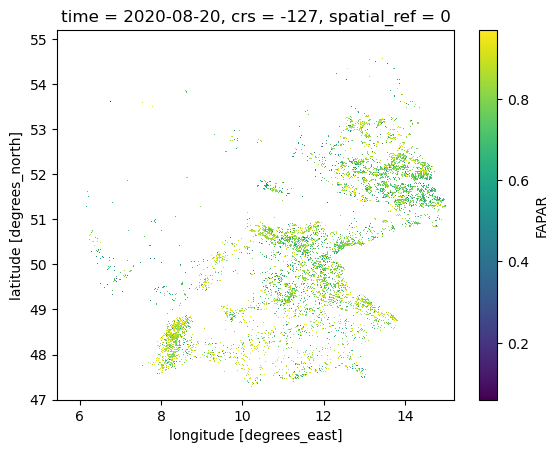

In [23]:
fapar_NL.plot()

In [24]:
# to get more information on pixel quality:
# count quality flag frequencies and pixels of high quality per year
# read in again quality flag lookup tables that were delivered with data
lut = pd.read_csv("./Raw/LAI_FAPAR_MODIS/MOD15A2H-061-FparLai-QC-lookup.csv")
lut_extra = pd.read_csv("./Raw/LAI_FAPAR_MODIS/MOD15A2H-061-FparExtra-QC-lookup.csv")

In [25]:
# rename columns with quality flags
lut.rename({"Value":'qa_flag'},axis=1, inplace= True)
lut_extra.rename({"Value":'qa_flag'},axis=1, inplace= True)

In [26]:
# read in tables with quality flag statistics that were also delivered with data
qa_stats = pd.read_csv("./Raw/LAI_FAPAR_MODIS/MOD15A2H-061-FparLai-QC-Statistics-QA.csv")
qa_extra_stats = pd.read_csv("./Raw/LAI_FAPAR_MODIS/MOD15A2H-061-FparExtra-QC-Statistics-QA.csv")

In [27]:
qa_stats

,File,aid,Date,0,8,16,32,40,48,65,73,81,97,105,113,157
0,FparLai_QC_2000049_aid0001,aid0001,2000-02-18,90305.0,138096.0,33112.0,4.0,29.0,6.0,NaN,NaN,NaN,34131.0,2145695.0,9928.0,203685
1,FparLai_QC_2000057_aid0001,aid0001,2000-02-26,1656241.0,342935.0,399211.0,54.0,81.0,12.0,NaN,NaN,NaN,20568.0,28856.0,3358.0,203675
2,FparLai_QC_2000065_aid0001,aid0001,2000-03-05,881479.0,697924.0,343175.0,38.0,77.0,6.0,NaN,NaN,NaN,42068.0,466372.0,20177.0,203675
3,FparLai_QC_2000073_aid0001,aid0001,2000-03-13,1531618.0,350810.0,327355.0,280.0,196.0,84.0,NaN,NaN,NaN,41075.0,180882.0,19016.0,203675
4,FparLai_QC_2000081_aid0001,aid0001,2000-03-21,1872020.0,130916.0,379768.0,662.0,207.0,156.0,NaN,NaN,NaN,19258.0,42850.0,5479.0,203675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,FparLai_QC_2024329_aid0001,aid0001,2024-11-24,119721.0,734.0,1681.0,2.0,1.0,2.0,1998489.0,186766.0,144503.0,NaN,NaN,NaN,203092
1135,FparLai_QC_2024337_aid0001,aid0001,2024-12-02,NaN,NaN,NaN,NaN,NaN,NaN,762915.0,1352806.0,336178.0,NaN,NaN,NaN,203092
1136,FparLai_QC_2024345_aid0001,aid0001,2024-12-10,NaN,NaN,NaN,NaN,NaN,NaN,487433.0,1793015.0,171451.0,NaN,NaN,NaN,203092
1137,FparLai_QC_2024353_aid0001,aid0001,2024-12-18,NaN,NaN,NaN,NaN,NaN,NaN,934354.0,1101062.0,416483.0,NaN,NaN,NaN,203092


In [28]:
qa_extra_stats

,File,aid,Date,0,1,2,4,5,6,8,...,194,196,197,198,200,201,202,204,205,206
0,FparExtra_QC_2000049_aid0001,aid0001,2000-02-18,958,934,77,149.0,16.0,NaN,2379,...,145.0,982.0,56.0,NaN,45006,25.0,NaN,64.0,NaN,NaN
1,FparExtra_QC_2000057_aid0001,aid0001,2000-02-26,457397,57174,3420,23428.0,1459.0,20.0,121903,...,265.0,348.0,27.0,2.0,82529,41.0,NaN,21.0,NaN,NaN
2,FparExtra_QC_2000065_aid0001,aid0001,2000-03-05,159712,24351,1731,19689.0,1474.0,2.0,146324,...,210.0,642.0,57.0,NaN,114962,13.0,NaN,133.0,NaN,NaN
3,FparExtra_QC_2000073_aid0001,aid0001,2000-03-13,140854,50139,2810,12099.0,1020.0,2.0,306192,...,254.0,344.0,42.0,2.0,111343,2.0,NaN,18.0,NaN,NaN
4,FparExtra_QC_2000081_aid0001,aid0001,2000-03-21,292162,69718,3743,13137.0,1201.0,7.0,396549,...,219.0,253.0,27.0,2.0,70560,NaN,NaN,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,FparExtra_QC_2024329_aid0001,aid0001,2024-11-24,313292,53467,3393,4935.0,615.0,44.0,240883,...,405.0,684.0,120.0,5.0,67395,2967.0,32.0,417.0,18.0,NaN
1135,FparExtra_QC_2024337_aid0001,aid0001,2024-12-02,119468,13821,529,13820.0,2314.0,17.0,56693,...,318.0,7124.0,1507.0,36.0,50817,569.0,5.0,232.0,2.0,4.0
1136,FparExtra_QC_2024345_aid0001,aid0001,2024-12-10,28362,4686,361,10845.0,778.0,5.0,44049,...,232.0,4529.0,536.0,12.0,15600,311.0,19.0,198.0,NaN,NaN
1137,FparExtra_QC_2024353_aid0001,aid0001,2024-12-18,164855,38625,2145,23310.0,1893.0,131.0,9689,...,551.0,15761.0,3314.0,30.0,22465,210.0,27.0,886.0,NaN,NaN


In [29]:
# drop unneeded columns
qa_stats = qa_stats.drop(["File", "aid"], axis=1)
qa_extra_stats = qa_extra_stats.drop(["File", "aid"], axis=1)

# extract year as new column
qa_stats["Year"] = qa_stats['Date'].astype(str).str[0:4]
qa_extra_stats["Year"] = qa_extra_stats['Date'].astype(str).str[0:4]

In [30]:
# create empty lists for pixel counts
years = []
pixel_counts = []
high_quality_pixel_counts = []
high_quality_extra_pixel_counts = []

In [31]:
# loop over each year to get yearly statistics of qa_stats
for year in range(2000, 2025):

    # get all dates from this year and extract them
    qa_stats_yearly = qa_stats[(qa_stats["Year"] == str(year))]

    # drop unneeded columns
    qa_stats_yearly = qa_stats_yearly.drop(["Date", "Year"], axis=1)

    # calculate sum of flag counts of dates in each year to get flag frequencies for this year
    df_qa_freq = pd.DataFrame(qa_stats_yearly.sum())

    # create new column with quality flag
    df_qa_freq["qa_flag"] = df_qa_freq.index

    # reset index
    df_qa_freq.reset_index(drop = True, inplace = True)

    # rename column with counts
    df_qa_freq.rename({0:'qa_flag_freq'},axis=1, inplace= True)

    # convert values to integer
    df_qa_freq = df_qa_freq.astype(int)

    # add information from lookup table to flags
    df_qa_freq = pd.merge(df_qa_freq, lut, on = "qa_flag")

    # save quality flag frequencies as csv
    df_qa_freq.to_csv(f"./Tables/FAPAR_Quality_Assessment/FAPAR_QA_Flag_Frequency_{year}.csv")

    # extract all quality flag values that are fit for our purpose and should be kept in the dataset
    df_qa_tokeep = df_qa_freq[(df_qa_freq["qa_flag"].isin(qa_tokeep))]

    # append counts to lists    
    years.append(year)
    pixel_counts.append(sum(df_qa_freq.qa_flag_freq))
    high_quality_pixel_counts.append(sum(df_qa_tokeep.qa_flag_freq))

In [32]:
# loop over each year to get yearly statistics of qa_extra_stats
for year in range(2000, 2025):

    # get all dates from this year and extract them
    qa_stats_yearly = qa_extra_stats[(qa_extra_stats["Year"] == str(year))]

    # drop unneeded columns
    qa_stats_yearly = qa_stats_yearly.drop(["Date", "Year"], axis=1)

    # calculate sum of flag counts of dates in each year to get flag frequencies for this year
    df_qa_freq = pd.DataFrame(qa_stats_yearly.sum())

    # create new column with quality flag
    df_qa_freq["qa_flag"] = df_qa_freq.index

    # reset index
    df_qa_freq.reset_index(drop = True, inplace = True)

    # rename column with counts
    df_qa_freq.rename({0:'qa_flag_freq'},axis=1, inplace= True)

    # convert values to integer
    df_qa_freq = df_qa_freq.astype(int)

    # add information from lookup table to flags
    df_qa_freq = pd.merge(df_qa_freq, lut_extra, on = "qa_flag")

    # save quality flag frequencies as csv
    df_qa_freq.to_csv(f"./Tables/FAPAR_Quality_Assessment/FAPAR_QA_Extra_Flag_Frequency_{year}.csv")

    # extract all quality flag values that are fit for our purpose and should be kept in the dataset
    df_qa_tokeep = df_qa_freq[(df_qa_freq["qa_flag"].isin(qa_extra_tokeep))]

    # append counts to lists    
    high_quality_extra_pixel_counts.append(sum(df_qa_tokeep.qa_flag_freq))

In [33]:
df_qa_pixel_counts = pd.DataFrame({"Year": years,
                                "Pixels": pixel_counts,
                                "High_Quality_Pixels": high_quality_pixel_counts,
                                "High_Quality_Extra_Pixels": high_quality_extra_pixel_counts})

In [34]:
df_qa_pixel_counts

,Year,Pixels,High_Quality_Pixels,High_Quality_Extra_Pixels
0,2000,103544649,51754697,38790399
1,2001,116819604,53132072,40262610
2,2002,122129586,59441203,42752948
3,2003,122129586,62129279,53376212
4,2004,122129586,55923111,42472285
5,2005,122129586,61489059,53815029
6,2006,122129586,54973943,46036219
7,2007,122129586,61861066,46481130
8,2008,122129586,59399323,47775363
9,2009,122129586,57033906,46123363


In [35]:
# save pixel counts as csv
df_qa_pixel_counts.to_csv("./Tables/FAPAR_Quality_Assessment/FAPAR_QA_Pixel_Counts_2000-2024.csv")